# How are in-demand skills trending for Data Scientist?

In [1]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Loading dataset from Hugging Face and converting it to a pandas DataFrame
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# Converting the 'job_posted_date' column to datetime format
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Converting 'job_skills' string representations of lists into actual Python lists
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
# Define the country of interest
v_job_country = 'India'

# Define the job title to focus on
v_job_title = 'Data Scientist'

# Number of top skills to display in plots and analysis
v_skills = 5

In [3]:
# Filter dataset for jobs matching the selected country and job title
df_DS_Ind = df[(df['job_country'] == v_job_country) & (df['job_title_short'] == v_job_title)].copy()

# Extract the month number from the job posting date for time-based analysis
df_DS_Ind['job_posted_month_no'] = df_DS_Ind['job_posted_date'].dt.month

# Explode the 'job_skills' list so each skill appears as a separate row
df_DS_Ind_explode = df_DS_Ind.explode('job_skills')

In [4]:
# Create a pivot table counting the occurrences of each skill per month
df_DS_Ind_pivot = df_DS_Ind_explode.pivot_table(
    index='job_posted_month_no',
    columns='job_skills',
    aggfunc='size',
    fill_value=0
)

# Add a 'Total' row summing the counts of each skill across all months
df_DS_Ind_pivot.loc['Total'] = df_DS_Ind_pivot.sum()

# Reorder the columns (skills) based on total counts in descending order
df_DS_Ind_pivot = df_DS_Ind_pivot[df_DS_Ind_pivot.loc['Total'].sort_values(ascending=False).index]

# Remove the 'Total' row after sorting
df_DS_Ind_pivot.drop('Total', inplace=True)

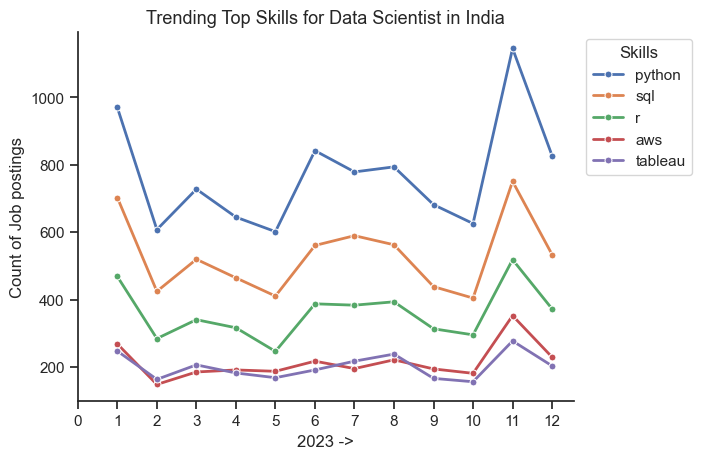

In [5]:
# Set Seaborn theme for clean plot aesthetics
sns.set_theme(style='ticks')

# Plot a line chart showing trends of top skills over months
sns.lineplot(data=df_DS_Ind_pivot.iloc[:, :v_skills],
             dashes=False,       # Use solid lines
             linewidth=2,
             marker='o',         # Mark each data point with a circle
             markersize=5)

# Remove top and right plot spines for a cleaner look
sns.despine()

# Set plot title dynamically with job title and country
plt.title(f'Trending Top Skills for {v_job_title} in {v_job_country}', fontsize=13)

# Label x and y axes
plt.xlabel('2023 ->')          # Indicating timeline across months in 2023
plt.ylabel('Count of Job postings')

# Set x-ticks to show all month indices (including potential padding)
plt.xticks(ticks=range(len(df_DS_Ind_pivot.index) + 1))

# Position legend outside the plot on the upper left side
plt.legend(title='Skills', bbox_to_anchor=(1.01, 1), loc='upper left')

# Display the plot
plt.show()

In [6]:
# Calculate the total number of job postings per month
DS_totals = df_DS_Ind.groupby('job_posted_month_no').size()

# Convert skill counts to percentages of total monthly job postings
df_DS_Ind_perc = df_DS_Ind_pivot.div(DS_totals / 100, axis=0)

In [7]:
# Reset index to convert 'job_posted_month_no' from index to a column for easier plotting/manipulation
df_DS_Ind_perc.reset_index(inplace=True)

In [8]:
# Convert month number to abbreviated month name (e.g., 1 -> Jan)
df_DS_Ind_perc['job_posted_month'] = df_DS_Ind_perc['job_posted_month_no'].apply(
    lambda x: pd.to_datetime(x, format='%m').strftime('%b')
)

# Set the month name as the index for better readability in plots
df_DS_Ind_perc.set_index('job_posted_month', inplace=True)

# Drop the original numeric month column as it's no longer needed
df_DS_Ind_perc.drop('job_posted_month_no', axis=1, inplace=True)

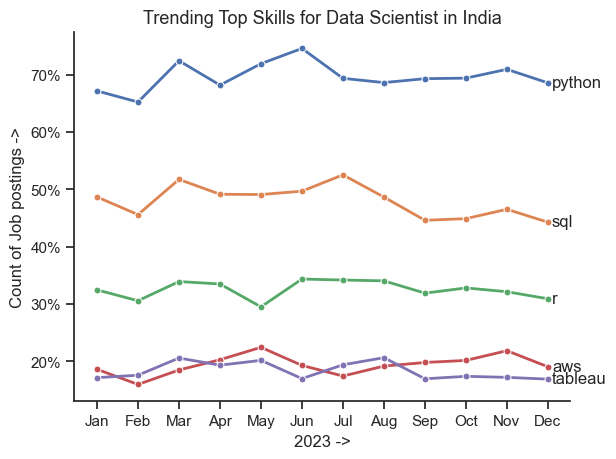

In [9]:
from matplotlib.ticker import PercentFormatter

# Set seaborn theme for plot styling
sns.set_theme(style='ticks')

# Plot lineplot of skill percentages over months for top skills
sns.lineplot(data=df_DS_Ind_perc.iloc[:, :v_skills],
             dashes=False,         # Solid lines
             linewidth=2,
             marker='o',           # Markers at data points
             markersize=5)

# Format y-axis labels as percentages
plt.gca().yaxis.set_major_formatter(PercentFormatter())

# Add skill names as text labels at the last data point on the right side
for i, txt in enumerate(df_DS_Ind_perc.columns[:v_skills]):
    plt.text(11.1, df_DS_Ind_perc.iloc[-1, i], txt, va='center')

# Set plot title and axis labels
plt.title(f'Trending Top Skills for {v_job_title} in {v_job_country}', fontsize=13)
plt.xlabel('2023 ->')
plt.ylabel('Count of Job postings ->')

# Remove top and right spines for cleaner look
sns.despine()

# Remove legend since labels are added directly on lines
plt.legend().remove()

# Show the final plot
plt.show()